In [ ]:
!pip install transformers datasets

In [ ]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
import random

import torch
import transformers
import numpy as np
import pandas as pd

## 1. Getting a dataset

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.


* `text`: a string feature.
* `label`: a classification label, with possible values including `neg` (0), `pos` (1).

In [ ]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# What features are there?
ds.column_names

{'train': ['text', 'label'],
 'test': ['text', 'label'],
 'unsupervised': ['text', 'label']}

In [ ]:
# Access the training split
ds["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
ds["train"][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

### 1.1 Inspect random examples from the dataset

In [ ]:
import random

random_indx = random.sample(range(len(ds["train"])),5)
random_samples = ds["train"][random_indx]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: This is the worst movie I have ever seen. I was going to get up and leave at Tape 4 but I stuck it out. I now consider myself a Masochist! Afghanistan? Come on guys! Who's the idiot who forgot to hide the Sanskrit billboards? I thought the lead actor(George Calil) was particularly inept. Apart from the bad acting and over zealous camera shake, I thought using the events of 9/11 as a reason to make "Larson the Lunatic Implodes, all over a screen near you" disgraceful and irreverent to the victims of 9/11. Using a phone call from Larson's wife, Sarah, supposedly from one of the terrorist held planes on that day, was appalling. The camera shake didn't make me feel sick, that cold hearted stunt did. | Label: 0
Text: When watching A Bug's Life for the first time in a long while, I couldn't help but see the comparisons with last year's Happy Feet. As far as the main storyline goes, they are very similar, an outcast doing what he can to fit in while 

In [ ]:
# Get unique label values
ds["train"].unique("label")

[0, 1]

In [ ]:
# Check number of each label
from collections import Counter

Counter(ds["train"]["label"])

Counter({0: 12500, 1: 12500})

## 2. Prepare data for text classification

### 2.1 Tokenize text data

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = "distilbert/distilbert-base-uncased")

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Test the tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

### 2.2 Making a preprocessing function to tokenize text

In [ ]:
def tokenize_text(examples):
  """ Tokenize a given example text and return the tokenized text."""
  return tokenizer(examples["text"], padding= "max_length", truncation=True)

In [ ]:
# Map our tokenize_text function to dataset
tokenized_dataset = ds.map(function = tokenize_text,
                           batched = True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scen

### Setup evaluation metrics

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

## 3. Setting up a model for training

In [ ]:
from transformers import AutoModelForSequenceClassification

# Setup model
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = "distilbert/distilbert-base-uncased",
    num_labels = 2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### 3.1 Create a directory for saving models

In [ ]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok = True)

# Create model save name
model_save_name = "text_clasification-imdb-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/text_clasification-imdb-distilbert-base-uncased')

### 3.2 Setting up traning arguments with TrainingArguments

Parameters we are going to use for training our model:
 * `output_dir`: the output directory where the model predictions and checkpoints will be written.
 * `learning_rate`: value of the initial learning rate for AdamW optimizer
 * `per_device_train_batch_size`:the batch size per device for training
 * `per device_eval_batch_size`: the batch size per device for evaluation
 * `num_train_epochs`:total number of training epochs to perfomr
 * `eval_strategy`: the evaluation strategy to adopt during training. Posible values are:
  * `"no"`: no evaluation is done during training
  * `"steps"`: evlauation is done every `eval_steps`
  * `"epoch"`: evaluation is done at the ed of each epoch
 * `save_strategy`: the checkpoing save stragtegy to adopt during training
 * `save_total_limit`: if a value is passed, will limit the total amout of checkpoints.
 * `use_cpu`:
 * `seed`:random seed for repdoducibility
 * `load_best_model_at_the_end`:whether or not to load the best model found during training.
 * `logging_strategy`:
 * `report_to`:

In [ ]:
from transformers import TrainingArguments
print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate = 2e-5,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    seed = 42,
    load_best_model_at_end = True,
    logging_strategy = "epoch",
    report_to = "none"
    )

[INFO] Saving model checkpoints to: models/text_clasification-imdb-distilbert-base-uncased


### 3.3 Setting up an instance of Trainer

In [ ]:
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
   model = model,
   args = training_args,
   train_dataset = tokenized_dataset["train"],
   eval_dataset = tokenized_dataset["test"],
   processing_class = tokenizer,
   compute_metrics = compute_accuracy
)

### 3.4 Training our text classification model

In [ ]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### 3.5 Save the model for later use

In [ ]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir = model_save_dir)

[INFO] Saving model to models/text_clasification-imdb-distilbert-base-uncased


### 3.6 Inspecting the model training metrics

In [ ]:
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics

trainer_history_metrics[:4]

[{'loss': 0.2749,
  'grad_norm': 7.20035982131958,
  'learning_rate': 8.002557544757034e-05,
  'epoch': 1.0,
  'step': 782},
 {'eval_loss': 0.24420976638793945,
  'eval_accuracy': 0.90036,
  'eval_runtime': 379.0087,
  'eval_samples_per_second': 65.962,
  'eval_steps_per_second': 2.063,
  'epoch': 1.0,
  'step': 782},
 {'loss': 0.123,
  'grad_norm': 2.6914479732513428,
  'learning_rate': 6.0025575447570334e-05,
  'epoch': 2.0,
  'step': 1564},
 {'eval_loss': 0.2562834918498993,
  'eval_accuracy': 0.9176,
  'eval_runtime': 377.7713,
  'eval_samples_per_second': 66.178,
  'eval_steps_per_second': 2.07,
  'epoch': 2.0,
  'step': 1564}]

In [ ]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 7.20035982131958,
  'learning_rate': 8.002557544757034e-05,
  'loss': 0.2749,
  'step': 782},
 {'epoch': 2.0,
  'grad_norm': 2.6914479732513428,
  'learning_rate': 6.0025575447570334e-05,
  'loss': 0.123,
  'step': 1564}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 0.90036,
  'eval_loss': 0.24420976638793945,
  'eval_runtime': 379.0087,
  'eval_samples_per_second': 65.962,
  'eval_steps_per_second': 2.063,
  'step': 782},
 {'epoch': 2.0,
  'eval_accuracy': 0.9176,
  'eval_loss': 0.2562834918498993,
  'eval_runtime': 377.7713,
  'eval_samples_per_second': 66.178,
  'eval_steps_per_second': 2.07,
  'step': 1564}]


In [ ]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df

,loss,grad_norm,learning_rate,epoch,step
0,0.2749,7.200360,8.002558e-05,1.0,782
1,0.1230,2.691448,6.002558e-05,2.0,1564
2,0.0513,0.044809,4.002558e-05,3.0,2346
3,0.0185,0.012952,2.002558e-05,4.0,3128
4,0.0074,0.009278,2.557545e-08,5.0,3910


In [ ]:
trainer_history_eval_df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.244210,0.90036,379.0087,65.962,2.063,1.0,782
1,0.256283,0.91760,377.7713,66.178,2.070,2.0,1564
2,0.317882,0.92168,377.2970,66.261,2.073,3.0,2346
3,0.449664,0.91544,376.8120,66.346,2.075,4.0,3128
4,0.455044,0.92528,377.0008,66.313,2.074,5.0,3910


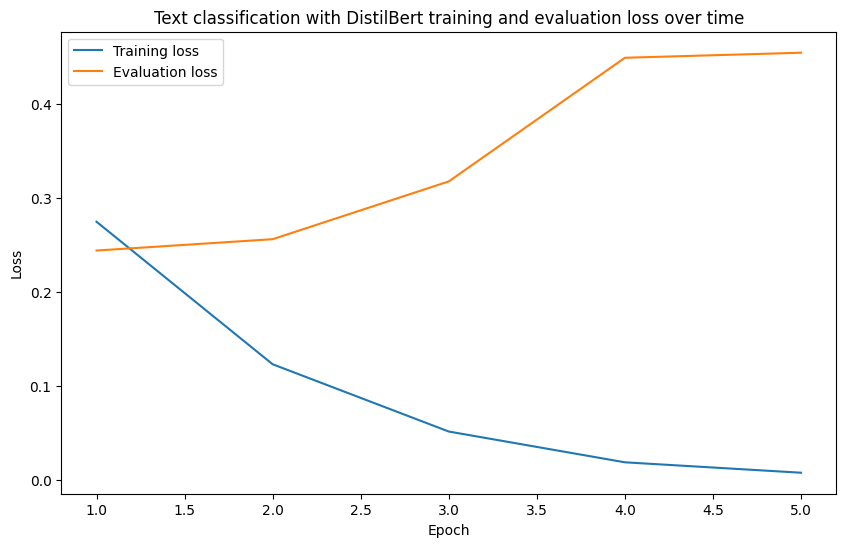

In [ ]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()